In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text


from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [2]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [3]:
stats = LeagueDashPlayerStats(measure_type_detailed_defense='Advanced', season_type_all_star='Playoffs')

In [4]:
base_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Base', season_type_all_star='Playoffs', per_mode_detailed='PerGame')
base_df = base_stats.get_data_frames()[0]

In [5]:
stats_df = stats.get_data_frames()[0]

In [6]:
stats_df = pd.merge(left=stats_df, right=base_df, on=('PLAYER_ID', 'PLAYER_NAME'))

In [7]:
reg_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Advanced')
reg_df = reg_stats.get_data_frames()[0]

base_reg_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='PerGame')
base_reg_df = base_stats.get_data_frames()[0]

reg_df = pd.merge(left=reg_df, right=base_reg_df, on=('PLAYER_ID', 'PLAYER_NAME'))

In [8]:
stats_df = stats_df.loc[(stats_df.GP_x >= 3) & (stats_df.MIN_x > 25)]

In [9]:
stats_ts = stats_df.loc[:, ['PLAYER_ID', 'PLAYER_NAME', 'TS_PCT', 'FGA_PG']]

In [10]:
reg_ts = reg_df.loc[:, ['PLAYER_ID', 'PLAYER_NAME', 'TS_PCT', 'FGA_PG']]

In [11]:
merged_df = pd.merge(left=reg_ts, right=stats_ts, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=('_REGULAR', '_PLAYOFFS'))

In [12]:
merged_df.loc[:, 'DIFF'] = merged_df.TS_PCT_PLAYOFFS - merged_df.TS_PCT_REGULAR

In [13]:
merged_df.sort_values(by='DIFF')

,PLAYER_ID,PLAYER_NAME,TS_PCT_REGULAR,FGA_PG_REGULAR,TS_PCT_PLAYOFFS,FGA_PG_PLAYOFFS,DIFF
50,1629652,Luguentz Dort,0.506,6.1,0.326,11.5,-0.180
56,1628467,Maxi Kleber,0.605,6.9,0.452,6.5,-0.153
45,203114,Khris Middleton,0.619,15.3,0.472,14.4,-0.147
66,202331,Paul George,0.589,16.3,0.480,17.7,-0.109
77,1627789,Timothe Luwawu-Cabarrot,0.599,5.7,0.498,14.8,-0.101
20,203095,Evan Fournier,0.595,14.1,0.496,11.4,-0.099
78,202699,Tobias Harris,0.556,16.3,0.461,15.0,-0.095
12,201980,Danny Green,0.552,7.0,0.462,8.4,-0.090
24,1629018,Gary Trent Jr.,0.587,7.2,0.499,9.0,-0.088
65,1627783,Pascal Siakam,0.554,18.4,0.478,17.6,-0.076


In [14]:
stats_df.TS_PCT.mean()

0.5816097560975609

In [15]:
reg_df.TS_PCT.mean()

0.5588229665071771

In [16]:
merged_df = merged_df.loc[merged_df.FGA_PG_PLAYOFFS >= 10]

In [17]:
bottom_10 = merged_df.sort_values(by='DIFF').iloc[:10]

In [18]:
bottom_10.loc[:, 'TS_PCT_REGULAR'] = bottom_10.TS_PCT_REGULAR * 100
bottom_10.loc[:, 'TS_PCT_PLAYOFFS'] = bottom_10.TS_PCT_PLAYOFFS * 100

In [19]:
plt.style.use('fivethirtyeight')

In [25]:
bottom_10 = bottom_10.sort_values(by='DIFF', ascending=False)

Text(40, -2.75, 'Source: stats.nba.com')

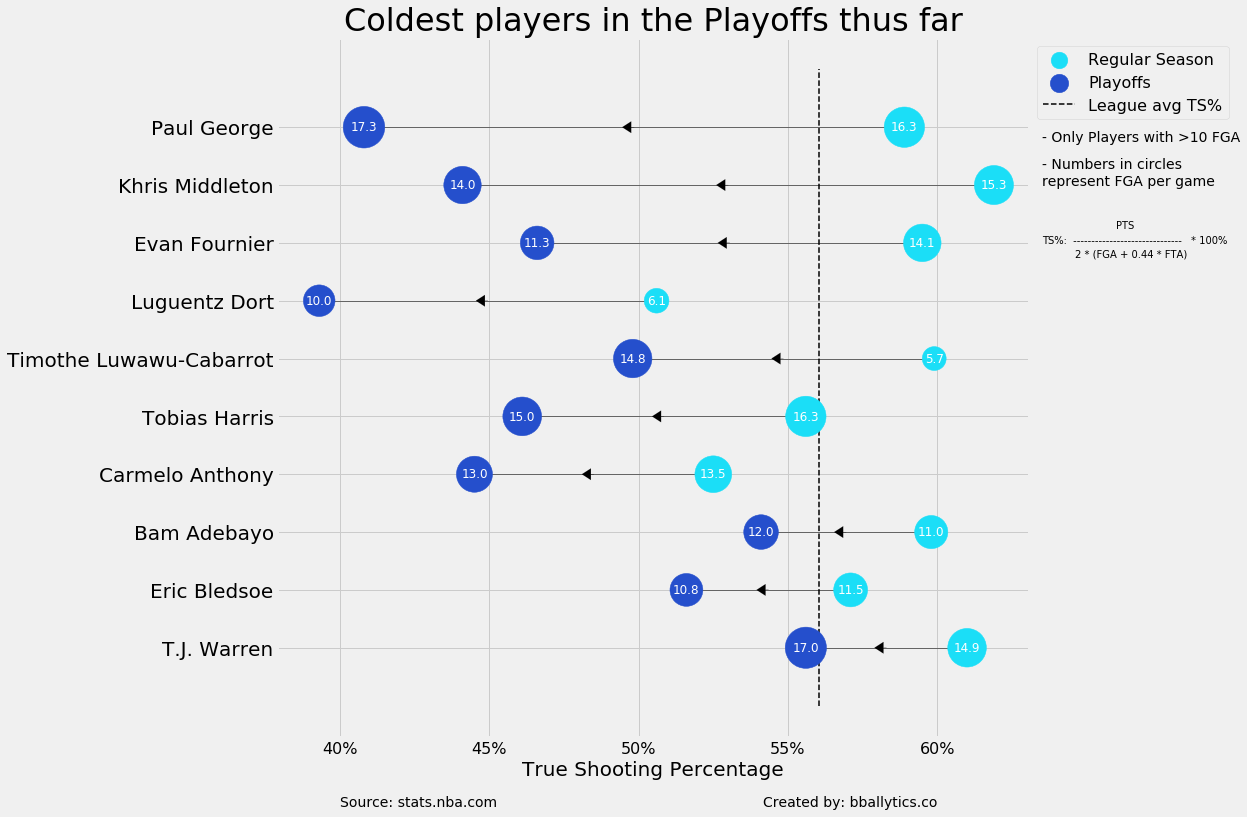

In [183]:
fig, ax = plt.subplots(figsize=(12, 12))
color_before = '#1BDEF7'
color_after = '#254FCC'
ax.scatter(x=bottom_10.TS_PCT_REGULAR, y=bottom_10.PLAYER_NAME, color=color_before, s=bottom_10.FGA_PG_REGULAR * 100, label='Regular Season', zorder=2)
ax.scatter(x=bottom_10.TS_PCT_PLAYOFFS, y=bottom_10.PLAYER_NAME, color=color_after, s=bottom_10.FGA_PG_PLAYOFFS * 100, label='Playoffs', zorder=2)

for index in range(len(bottom_10)):
    item = bottom_10.iloc[index]
    diff = item.DIFF * 100
    #print(item.TS_PCT_PLAYOFFS + 2 * diff / 3)
    ax.arrow(x=item.TS_PCT_REGULAR, y=index, dx=diff, dy=0, color='black', shape='full', head_width=0, zorder=1)
    ax.arrow(x=item.TS_PCT_REGULAR + diff / 2, y=index, dx=-0.1, lw=0.1, dy=0, color='black', shape='full', head_width=0.2, head_length=0.3, zorder=1)
    ax.text(x=item.TS_PCT_REGULAR, y=index, s=item.FGA_PG_REGULAR, ha='center', va='center', size=12, color='white')
    ax.text(x=item.TS_PCT_PLAYOFFS, y=index, s=item.FGA_PG_PLAYOFFS, ha='center', va='center', size=12, color='white')

ax.set_xlabel("True Shooting Percentage", size=20)
ax.set_xticklabels([f"{item}%" for item in range(35, 65, 5)], size=16)
ax.set_title("Coldest players in the Playoffs thus far", size=32)
ax.set_yticklabels([name for name in bottom_10.PLAYER_NAME], size=20)
ax.text(x=66, y=7.25, s='PTS', size=10)
ax.text(x=63.5, y=7, s='TS%:  ------------------------------', size=10)
ax.text(x=66.5, y=6.75, s='2 * (FGA + 0.44 * FTA)', ha='center', size=10)
ax.text(x=68.5, y=7, s='* 100%', size=10)

ax.text(x=63.5, y=8.75, s='- Only Players with >10 FGA')
ax.text(x=63.5, y=8, s='- Numbers in circles\nrepresent FGA per game')
ax.vlines(x=reg_df.TS_PCT.mean() * 100, ymin=-1, ymax=10, ls='--', lw=1.5, zorder=1, label='League avg TS%')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16, markerscale=0.5)

ax.text(x=60, y=-2.75, s='Created by: bballytics.co', ha='right', size=14)
ax.text(x=40, y=-2.75, s='Source: stats.nba.com', ha='left', size=14)

In [20]:
top_10 = merged_df.sort_values(by='DIFF', ascending=False).iloc[:10]
top_10.loc[:, 'TS_PCT_REGULAR'] = top_10.TS_PCT_REGULAR * 100
top_10.loc[:, 'TS_PCT_PLAYOFFS'] = top_10.TS_PCT_PLAYOFFS * 100
top_10 = top_10.sort_values(by='DIFF', ascending=True)

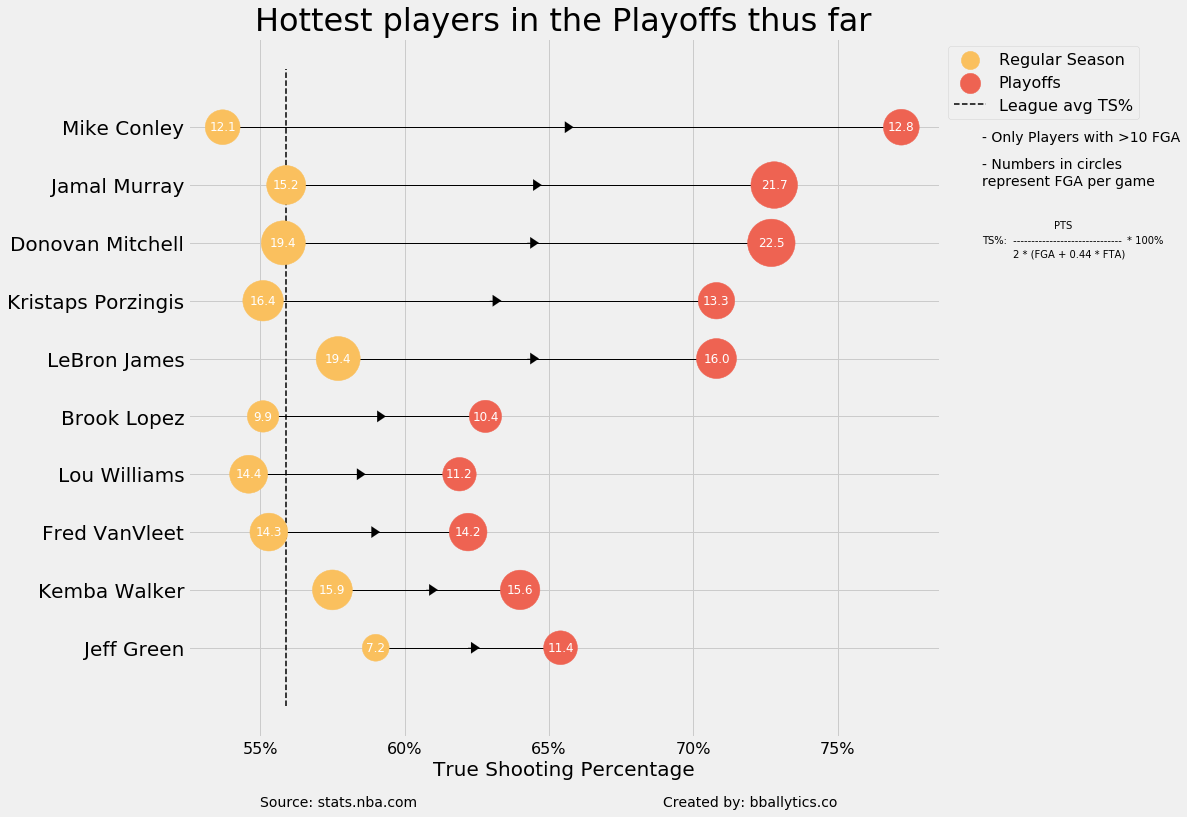

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))

color_before = '#FAC05E'
color_after = '#EE6352'

ax.scatter(x=top_10.TS_PCT_REGULAR, y=top_10.PLAYER_NAME, color=color_before, s=top_10.FGA_PG_REGULAR * 100, label='Regular Season', zorder=2)
ax.scatter(x=top_10.TS_PCT_PLAYOFFS, y=top_10.PLAYER_NAME, color=color_after, s=top_10.FGA_PG_PLAYOFFS * 100, label='Playoffs', zorder=2)

for index in range(len(top_10)):
    item = top_10.iloc[index]
    diff = item.DIFF * 100
    #print(item.TS_PCT_PLAYOFFS + 2 * diff / 3)
    if index == 10:
        ax.arrow(x=item.TS_PCT_REGULAR, y=index, dx=diff, dy=0, color='black', shape='full', head_width=0, zorder=1, lw=0.1)
    else:
        ax.arrow(x=item.TS_PCT_REGULAR, y=index, dx=diff, dy=0, color='black', shape='full', head_width=0, zorder=1, lw=1)
    ax.arrow(x=item.TS_PCT_REGULAR + diff / 2, y=index, dx=0.1, lw=0.1, dy=0, color='black', shape='full', head_width=0.2, head_length=0.3, zorder=1)
    ax.text(x=item.TS_PCT_REGULAR, y=index, s=item.FGA_PG_REGULAR, ha='center', va='center', size=12, color='white')
    ax.text(x=item.TS_PCT_PLAYOFFS, y=index, s=item.FGA_PG_PLAYOFFS, ha='center', va='center', size=12, color='white')

ax.set_xlabel("True Shooting Percentage", size=20)
ax.set_xticklabels([f"{item}%" for item in range(50, 80, 5)], size=16)
ax.set_title("Hottest players in the Playoffs thus far", size=32)
ax.set_yticklabels([name for name in top_10.PLAYER_NAME], size=20)

ax.text(x=80, y=8.75, s='- Only Players with >10 FGA')
ax.text(x=80, y=8, s='- Numbers in circles\nrepresent FGA per game')
ax.text(x=82.5, y=7.25, s='PTS', size=10)
ax.text(x=80, y=7, s='TS%:  ------------------------------', size=10)
ax.text(x=83, y=6.75, s='2 * (FGA + 0.44 * FTA)', ha='center', size=10)
ax.text(x=85, y=7, s='* 100%', size=10)

#ax.text(x=80.5, y=6, s=r'\frac{PTS}{2 * (FGA + 0.44 * FTA)}')
#ax.set_title(r'\frac{PTS}{2 * (FGA + 0.44 * FTA)}', fontsize=16, color='r')
ax.vlines(x=reg_df.TS_PCT.mean() * 100, ymin=-1, ymax=10, ls='--', lw=1.5, zorder=1, label='League avg TS%')
ax.text(x=75, y=-2.75, s='Created by: bballytics.co', ha='right', size=14)
ax.text(x=55, y=-2.75, s='Source: stats.nba.com', ha='left', size=14)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16, markerscale=0.5)

Text(35, -1.5, 'Source: stats.nba.com')

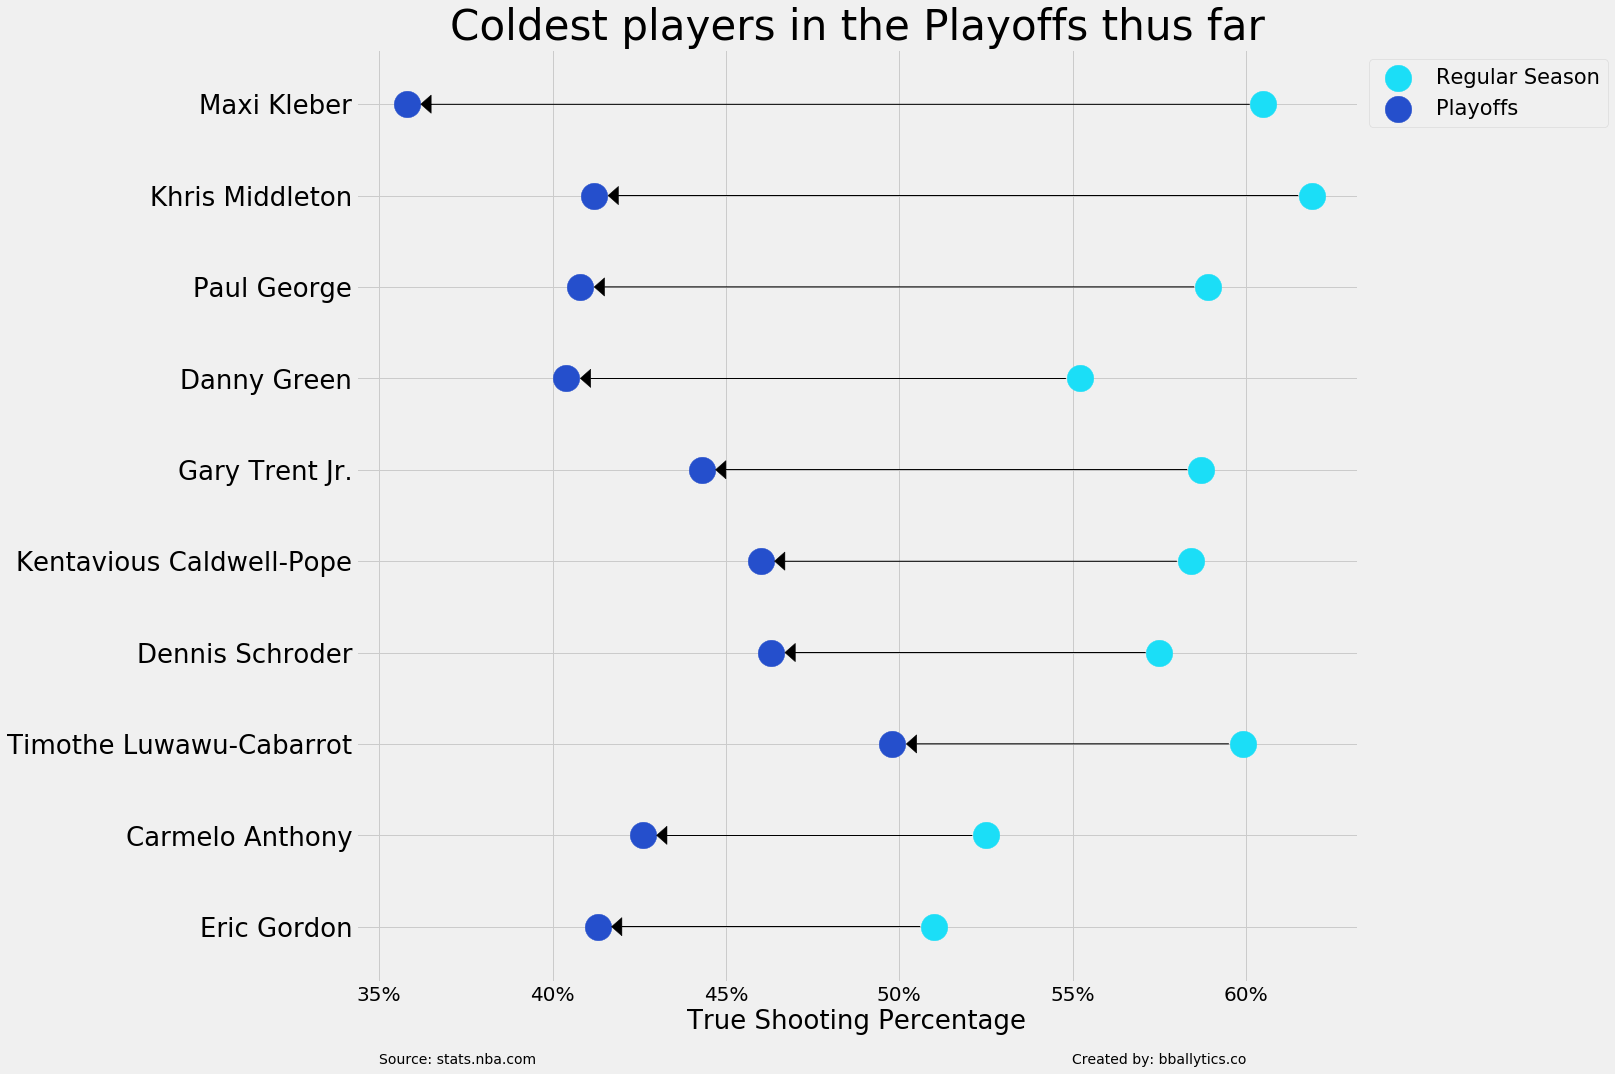

In [110]:
fig, ax = plt.subplots(figsize=(16, 16))

ax.scatter(x=bottom_10.TS_PCT_REGULAR, y=bottom_10.PLAYER_NAME, color=color_before, s=700, label='Regular Season')
ax.scatter(x=bottom_10.TS_PCT_PLAYOFFS, y=bottom_10.PLAYER_NAME, color=color_after, s=700, label='Playoffs')

for index in range(len(bottom_10)):
    item = bottom_10.iloc[index]
    ax.arrow(x=item.TS_PCT_REGULAR - 0.4, y=index, dx=(item.TS_PCT_PLAYOFFS - item.TS_PCT_REGULAR + 1.1), dy=0, color='black', shape='full', head_width=0.2)

ax.set_xlabel("True Shooting Percentage", size=26)
ax.set_xticklabels([f"{item}%" for item in range(30, 65, 5)], size=20)
ax.set_title("Coldest players in the Playoffs thus far", size=42)
ax.set_yticklabels([name for name in bottom_10.PLAYER_NAME], size=26)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=21)

ax.text(x=60, y=-1.5, s='Created by: bballytics.co', ha='right', size=14)
ax.text(x=35, y=-1.5, s='Source: stats.nba.com', ha='left', size=14)